In [1]:
ifile = '../out/associations_annotated.tsv'
sfile = '../data/reference.fasta'
kfile = '../out/ko_scores_annotated.txt'
ffile = '../out/SGD_sorted_features.bed'
efile = '../out/gwas_enrichments.tsv'
sgd = '../out/SGD_features.tab'
cofile = 'natural_sorted.txt'

In [2]:
# plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.colors as mc
import colorsys

from adjustText import adjust_text

sns.set_style('white')

plt.rc('font', size=12)

In [3]:
import roman
import numpy as np
import pandas as pd
from Bio import SeqIO
from scipy import stats

In [4]:
co = [x.rstrip() for x in open(cofile)]

In [5]:
g = pd.read_table(sgd, sep='\t', header=None)
gn = g[g[1] == 'ORF'].set_index(3)[4].dropna().to_dict()
rgn = g[g[1] == 'ORF'].set_index(4)[3].dropna().to_dict()
gd = g[g[1] == 'ORF'].set_index(3)[15].dropna().to_dict()

In [6]:
e = pd.read_table(efile)

In [7]:
e[(e['gpval'] == 1E-6) &
  (e['condition'] != 'all') &
  (e['nintersection'] > 0) &
  (e['set'] == 'all')].sort_values('nintersection', ascending=False)['condition'].unique()

array(['Caffeine 15mM (48H)', 'Cadmium chloride (48H)', 'NaCl 0.4M (48H)',
       'NaCl 0.6M (48H)', 'Glycerol 2% (48H)', 'Amphotericin B (48H)',
       'Caffeine 20mM (48H)', 'Cyclohexamide (48H)',
       'NaCl 0.4M + 39ºC (48H)', 'NaCl 0.4M + 39ºC (72H)',
       'NaCl 0.6M + 39ºC (72H)', 'Caspofungin (48H)',
       'Amphotericin B + anaerobic (48H)'], dtype=object)

In [8]:
ed = e[(e['gpval'] == 1E-6) &
  (e['kpval'] == 0.05) &
  (e['condition'] != 'all') &
  (e['nintersection'] > 0) &
  (e['set'] == 'all')].groupby('condition').apply(lambda x: sorted({y for z in x['intersection'].values
                                                                    for y in z.split(',')})).to_dict()

In [9]:
ed

{'Amphotericin B (48H)': ['YDR276C', 'YJR059W'],
 'Amphotericin B + anaerobic (48H)': ['YOL086C'],
 'Cadmium chloride (48H)': ['YBR295W', 'YBR296C', 'YHL017W'],
 'Caffeine 15mM (48H)': ['YCR082W', 'YDR096W', 'YHR162W'],
 'Caffeine 20mM (48H)': ['YIL112W'],
 'Caspofungin (48H)': ['YDL241W'],
 'Cyclohexamide (48H)': ['YOR153W'],
 'Glycerol 2% (48H)': ['YKL101W', 'YPR140W'],
 'NaCl 0.4M (48H)': ['YHR146W', 'YJL082W', 'YPR013C'],
 'NaCl 0.4M + 39ºC (48H)': ['YDL026W'],
 'NaCl 0.4M + 39ºC (72H)': ['YDL026W'],
 'NaCl 0.6M (48H)': ['YGL007W', 'YHR146W'],
 'NaCl 0.6M + 39ºC (72H)': ['YDR073W']}

In [10]:
eb = e[(e['gpval'] == 1E-6) &
       (e['kpval'] == 0.05) &
       (e['condition'] != 'all') &
       (e['set'] == 'all') &
       (e['nstrains'] == 1)].sort_values('pvalue').set_index('condition')
# eb['sign'] = -np.log10(eb['pvalue'])
eb['sign'] = eb['nintersection']

In [11]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    
    source: https://stackoverflow.com/a/49601444/1237531
    """
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [12]:
def newyork_plot(m, s, cond):
    plt.figure(figsize=(12, 12))

    plt.subplot(511)

    df = m.loc[cond]

    color = sns.xkcd_rgb['dark grey']

    xticks = []
    i = 0
    for c in range(1, 17):
        if c % 2:
            color = lighten_color(color, 0.5)
        else:
            color = sns.xkcd_rgb['dark grey']
        plt.plot(df.loc[c, 'pos'] + i,
                 -np.log10(df.loc[c, 'pvalue']),
                 '.',
                 color=color,
                 rasterized=True)
        xticks.append((i + d[c]/2, roman.toRoman(c)))
        i += d[c]

    plt.ylabel('association\n$-log_{10}(pvalue)$')
    plt.xticks([])
    plt.title(cond)
    plt.axhline(6,
                color='grey',
                ls='dashed')
    # plt.xticks([x for x, y, in xticks],
    #            [y for x, y, in xticks],)
    
    plt.xlim(0, i)

    ylim = -np.log10(s.loc[cond]['qvalue'])

    for i, strain in enumerate(strains):
        plt.subplot(5, 1, i+2)

        df = s.loc[cond]
        df = df.loc[strain]

        color = cstrains[strain]

        xticks = []
        i = 0
        for c in range(1, 17):
            if c % 2:
                color = lighten_color(color, 0.5)
            else:
                color = cstrains[strain]
            try:
                plt.plot(df.loc[c, 'pos'] + i,
                         -np.log10(df.loc[c, 'qvalue']),
                         '.',
                         color=color,
                         rasterized=True)
            except:
                pass
            xticks.append((i + d[c]/2, roman.toRoman(c)))
            i += d[c]
        plt.xticks([])
        plt.ylim(-2, ylim.max()+2)
        plt.ylabel('KO qvalue\n(%s)' % strain)
        plt.axhline(2,
                    color='grey',
                    ls='dashed')
        
        plt.xlim(0, i)

    plt.xticks([x for x, y, in xticks],
               [y for x, y, in xticks],)

    plt.subplots_adjust(hspace=0);

In [13]:
def plot_example(m, s, d, cond,
                 c, ming, maxg,
                 genes, gpos, gn):
    plt.figure(figsize=(5, 3.5))

    minp = ming-75000
    maxp = maxg+75000
    if minp < 0:
        minp = 0
    if maxp > d[c]:
        maxp = d[c]

    df = m.loc[cond]

    gs = plt.GridSpec(5, 1,
                      hspace=0.0,
                      height_ratios=[1, 0.5, 0.5, 0.5, 0.5])

    ax = plt.subplot(gs[0])
    plt.sca(ax)

    color = sns.xkcd_rgb['dark grey']
    plt.plot(df.loc[c, 'pos'],
             -np.log10(df.loc[c, 'pvalue']),
             '.',
             color=lighten_color(color, 0.5),
             rasterized=True)
    df1 = df[(df['pvalue'] <= 1E-6) &
             (df['pos'] >= ming-1500) &
             (df['pos'] <= maxg+1500)]
    obj = plt.plot(df1.loc[c, 'pos'],
             -np.log10(df1.loc[c, 'pvalue']),
             'o',
             color=color,
             rasterized=True)
    txts = []
    for gene, pos in zip(genes, gpos):
        txts.append(plt.text(pos, -np.log10(df[(df['pos'] >= pos-1500) &
                                     (df['pos'] <= pos+1500)]['pvalue'].min()),
                 gn.get(gene, gene),
                 ha='center',
                 va='center'))
    plt.ylabel('$-log_{10}(pvalue)$\nassociation')
    plt.xticks([])
    plt.title(cond)
    plt.xlim(minp, maxp)
    plt.axhline(6,
                color='grey',
                ls='dashed')
    plt.ylim(-0.5, -np.log10(df1['pvalue'].min())+1)
    plt.fill_between([ming-1500, maxg+1500], -.5, plt.gca().get_ylim()[1]+10,
                     color=sns.xkcd_rgb['light grey'],
                     alpha=0.66)

    iterations = adjust_text(txts,
                             arrowprops=dict(arrowstyle='-',
                                             color='k'),
                             add_objects=obj)
    
    ylim = -np.log10(s[(s['pos'] >= minp) &
                       (s['pos'] <= maxp)].loc[(cond, slice(None), c),]['qvalue'])

    for i, strain in enumerate(strains):
        ax = plt.subplot(gs[i+1])
        plt.sca(ax)

        df = s.loc[cond]
        df = df.loc[strain]

        color = cstrains[strain]
        try:
            plt.plot(df.loc[c, 'pos'],
                     -np.log10(df.loc[c, 'qvalue']),
                     '.',
                     color=lighten_color(color, 0.5),
                     rasterized=True)
        except:
            pass

        df1 = df[(df['gene'].isin(genes)) &
                 (df['qvalue'] <= 0.05)]
        try:
            plt.plot(df1.loc[c, 'pos'],
                     -np.log10(df1.loc[c, 'qvalue']),
                     'o',
                     color=color,
                     rasterized=True)
        except:
            pass

        if i != 3:
            plt.xticks([])
        plt.xlim(minp, maxp)
        plt.ylim(-0.5, ylim.max()+2)
        plt.ylabel(strain)
        plt.axhline(1.3010299956639813,
                    color='grey',
                    ls='dashed')
        plt.fill_between([ming-1500, maxg+1500], -0.5, plt.gca().get_ylim()[1]+10,
                         color=sns.xkcd_rgb['light grey'],
                         alpha=0.66)

    plt.xlabel('Position (chr%s)' % roman.toRoman(c));

In [14]:
f = pd.read_table(ffile,
                  header=None)
f.columns = ['chrom', 'start', 'stop', 'gene']
f['pos'] = (f['start'] + f['stop']) / 2

In [15]:
d = {}
for s in SeqIO.parse(sfile, 'fasta'):
    try:
        seq = roman.fromRoman(s.id.replace('chr', ''))
        d[seq] = len(s)
    except:
        pass

In [16]:
m = pd.read_table(ifile).set_index(['condition',
                                    'chrom']).sort_index()

In [17]:
s = pd.read_table(kfile, index_col=[0, 2, 1])
agenes = None
for st in {x[0] for x in s.index}:
    gs = {x[0] for x in s.loc[st].index}
    if agenes is None:
        agenes = gs
    else:
        agenes = agenes.intersection(gs)
s = pd.read_table(kfile).set_index('gene'
        ).loc[agenes].reset_index().set_index([
        'condition',
        'strain', 'chrom']).sort_index()

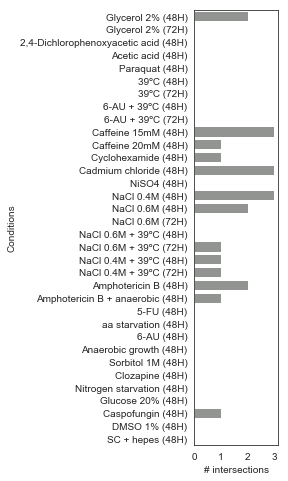

In [18]:
plt.figure(figsize=(1.5, 8))

sns.barplot(data=eb.reindex(co).reset_index(),
            x='sign',
            y='condition',
            color=sns.xkcd_rgb['grey'])

plt.xlabel('# intersections')
plt.ylabel('Conditions')
plt.xticks([0, 1, 2, 3]);

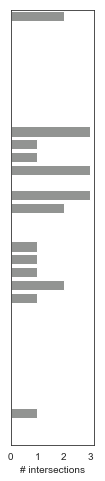

In [19]:
plt.figure(figsize=(1.5, 8))

sns.barplot(data=eb.reindex(co).reset_index(),
            x='sign',
            y='condition',
            color=sns.xkcd_rgb['grey'])

plt.xlabel('# intersections')
plt.ylabel('')
plt.yticks([])
plt.xticks([0, 1, 2, 3])
plt.savefig('gwas_intersection.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('gwas_intersection.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [20]:
y = m[m['pvalue'] <= 1E-6].groupby('condition')['pvalue'].count()

In [21]:
x = s[s['qvalue'] <= 0.05].groupby('condition')['qvalue'].count()

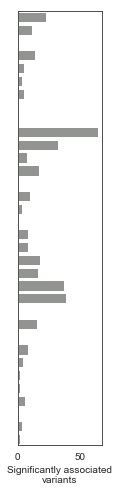

In [22]:
plt.figure(figsize=(1.5, 8))

sns.barplot(data=y.reindex(co).reset_index(),
            y='condition',
            x='pvalue',
            color=sns.xkcd_rgb['grey'])

plt.yticks([])
plt.ylabel('')
plt.xlabel('Significantly associated\nvariants')

plt.savefig('gwas_overview.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('gwas_overview.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

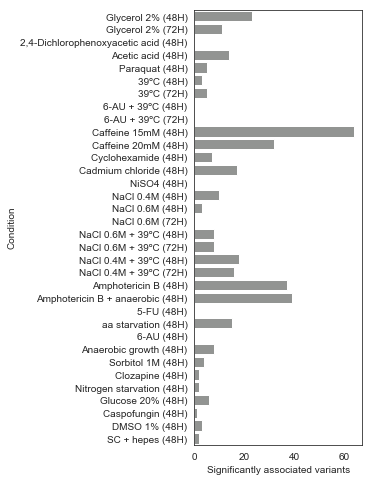

In [23]:
plt.figure(figsize=(3, 8))

sns.barplot(data=y.reindex(co).reset_index(),
            y='condition',
            x='pvalue',
            color=sns.xkcd_rgb['grey'])

plt.ylabel('Condition')
plt.xlabel('Significantly associated variants')

plt.savefig('gwas_overview_labels.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('gwas_overview_labels.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [24]:
agenes = agenes.intersection(f['gene'].unique())

In [25]:
conds = sorted({x[0] for x in m.index}.intersection({x[0] for x in s.index}))

In [26]:
strains = ['S288C', 'Y55',
           'UWOP', 'YPS']
cstrains = {x: c
            for x, c in zip(strains, sns.color_palette('Set1', len(strains)))}

In [27]:
sorted(ed.keys())

['Amphotericin B (48H)',
 'Amphotericin B + anaerobic (48H)',
 'Cadmium chloride (48H)',
 'Caffeine 15mM (48H)',
 'Caffeine 20mM (48H)',
 'Caspofungin (48H)',
 'Cyclohexamide (48H)',
 'Glycerol 2% (48H)',
 'NaCl 0.4M (48H)',
 'NaCl 0.4M + 39ºC (48H)',
 'NaCl 0.4M + 39ºC (72H)',
 'NaCl 0.6M (48H)',
 'NaCl 0.6M + 39ºC (72H)']

In [28]:
i = 0

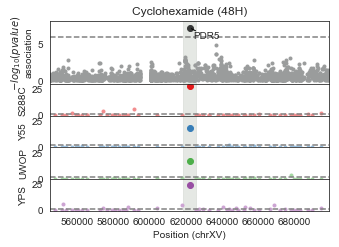

In [29]:
cond = 'Cyclohexamide (48H)'
c = 15
ming = 619840
maxg = 624375
genes = ['YOR153W']
gpos = [622107.5]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

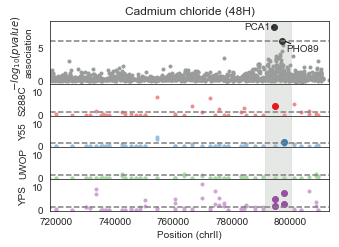

In [30]:
cond = 'Cadmium chloride (48H)'
c = 2
ming = 792849
maxg = 798522
genes = ['YBR295W',
         'YBR296C']
gpos = [794674.0,
        797660.0]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

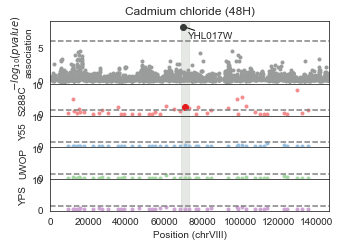

In [31]:
cond = 'Cadmium chloride (48H)'
c = 8
ming = 70276
maxg = 71874
genes = ['YHL017W']
gpos = [71075]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

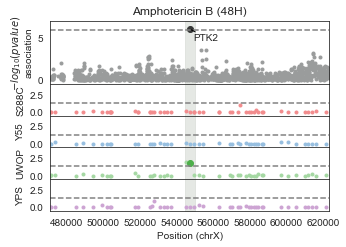

In [32]:
cond = 'Amphotericin B (48H)'
c = 10
ming = 545787
maxg = 548243
genes = ['YJR059W']
gpos = [547015]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

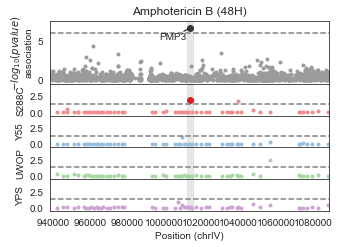

In [33]:
cond = 'Amphotericin B (48H)'
c = 4
ming = 1013476
maxg = 1013643
genes = ['YDR276C']
gpos = [1013559.5]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

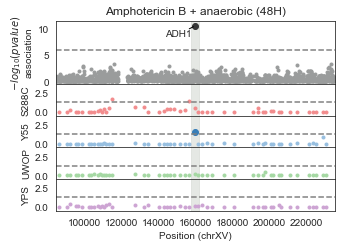

In [34]:
cond = 'Amphotericin B + anaerobic (48H)'
c = 15
ming = 159548
maxg = 160594
genes = ['YOL086C']
gpos = [160071]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

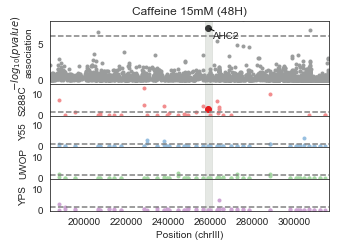

In [35]:
cond = 'Caffeine 15mM (48H)'
c = 3
ming = 258883
maxg = 259269
genes = ['YCR082W']
gpos = [259076.0]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

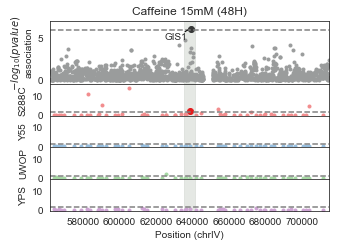

In [36]:
cond = 'Caffeine 15mM (48H)'
c = 4
ming = 637139
maxg = 639823
genes = ['YDR096W']
gpos = [638481.0]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

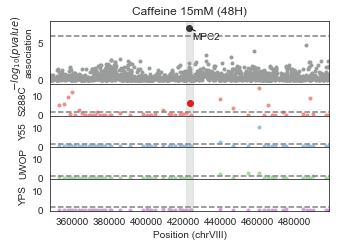

In [37]:
cond = 'Caffeine 15mM (48H)'
c = 8
ming = 423072
maxg = 423461
genes = ['YHR162W']
gpos = [423266.5]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

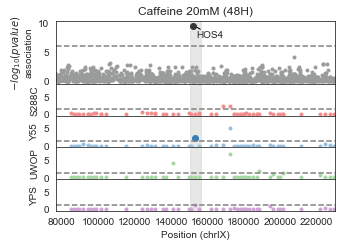

In [38]:
cond = 'Caffeine 20mM (48H)'
c = 9
ming = 151595
maxg = 154846
genes = ['YIL112W']
gpos = [153220.5]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

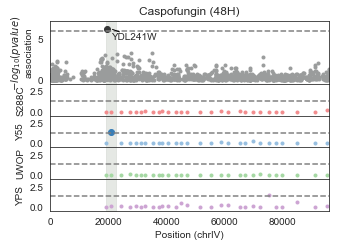

In [39]:
cond = 'Caspofungin (48H)'
c = 4
ming = 20635
maxg = 21006
genes = ['YDL241W']
gpos = [20820.5]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

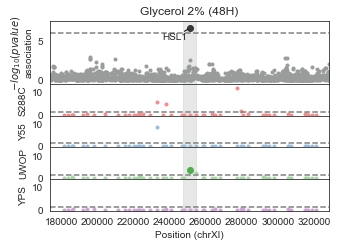

In [40]:
cond = 'Glycerol 2% (48H)'
c = 11
ming = 248920
maxg = 253476
genes = ['YKL101W']
gpos = [251198.0]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

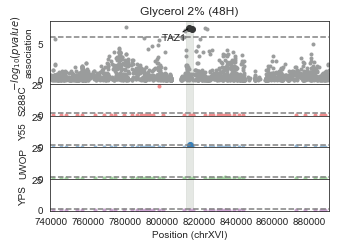

In [41]:
cond = 'Glycerol 2% (48H)'
c = 16
ming = 814391
maxg = 815536
genes = ['YPR140W']
gpos = [814963.5]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

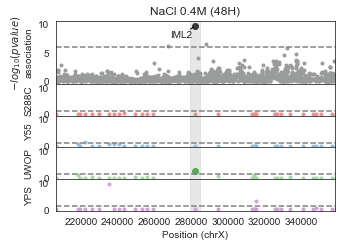

In [42]:
cond = 'NaCl 0.4M (48H)'
c = 10
ming = 281185
maxg = 283380
genes = ['YJL082W']
gpos = [282282.5]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

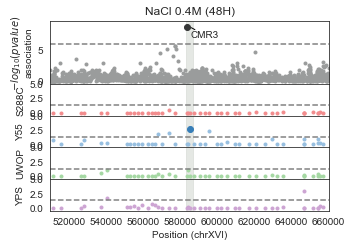

In [43]:
cond = 'NaCl 0.4M (48H)'
c = 16
ming = 584632
maxg = 585585
genes = ['YPR013C']
gpos = [585108.5]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

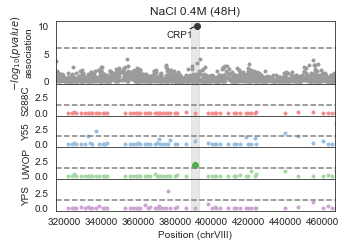

In [44]:
cond = 'NaCl 0.4M (48H)'
c = 8
ming = 390300
maxg = 391697
genes = ['YHR146W']
gpos = [390998.5]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

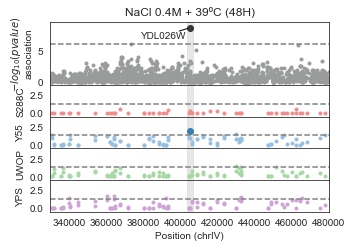

In [45]:
cond = 'NaCl 0.4M + 39ºC (48H)'
c = 4
ming = 404749
maxg = 405060
genes = ['YDL026W']
gpos = [404904.5]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

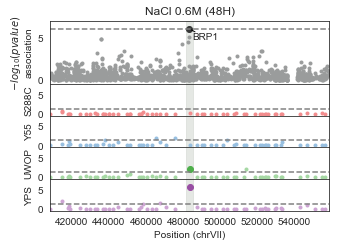

In [46]:
cond = 'NaCl 0.6M (48H)'
c = 7
ming = 483260
maxg = 483637
genes = ['YGL007W']
gpos = [483448.5]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

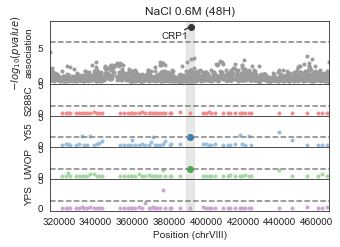

In [47]:
cond = 'NaCl 0.6M (48H)'
c = 8
ming = 390300
maxg = 391697
genes = ['YHR146W']
gpos = [390998.5]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

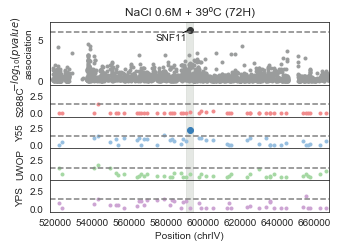

In [48]:
cond = 'NaCl 0.6M + 39ºC (72H)'
c = 4
ming = 592439
maxg = 592948
genes = ['YDR073W']
gpos = [592693.5]
plot_example(m, s, d, cond,
             c, ming, maxg,
             genes, gpos, gn)
cond = cond.encode('ascii', 'replace').decode()
plt.savefig('%s_%d.png' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('%s_%d.svg' % (cond, i),
            dpi=300, bbox_inches='tight',
            transparent=True)
i += 1;

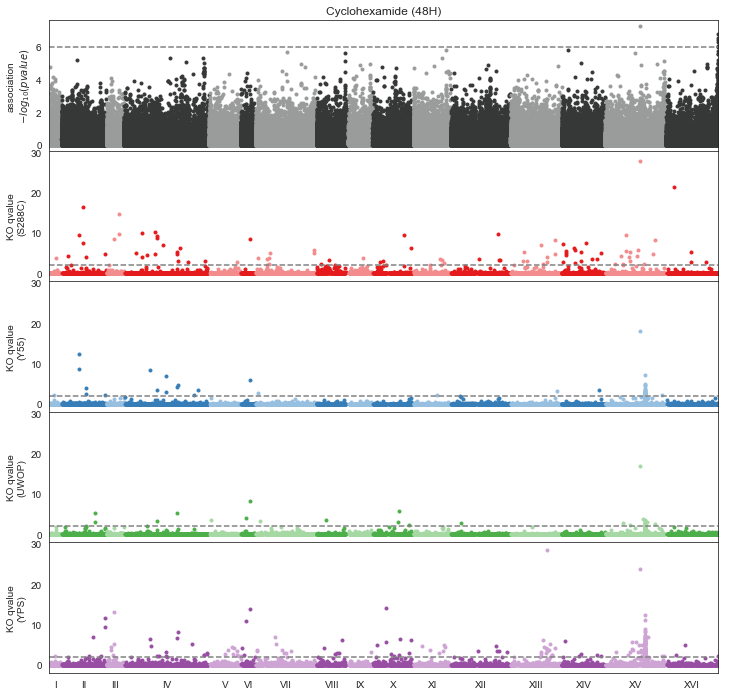

In [49]:
newyork_plot(m, s, 'Cyclohexamide (48H)')

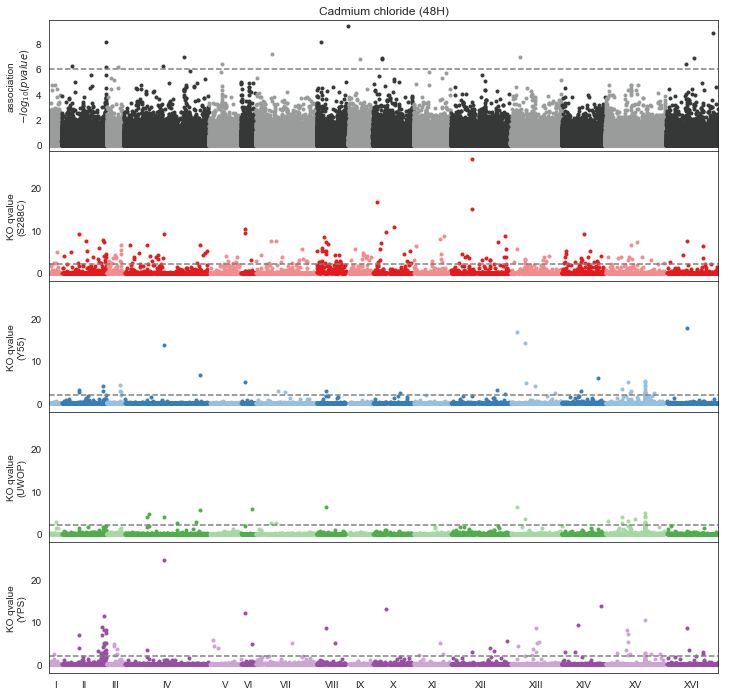

In [50]:
newyork_plot(m, s, 'Cadmium chloride (48H)')